<a href="https://colab.research.google.com/github/yashpatil454/Deep_Audio_Classifier_Convolutinal_NN/blob/main/Deep_Audio_Classifier_Convolutional_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashpatil454","key":"e4f700df75f92a9ab4281ff6cbc9a747"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

100% 601M/604M [00:27<00:00, 23.9MB/s]
100% 604M/604M [00:28<00:00, 22.6MB/s]


In [4]:
!unzip /content/z-by-hp-unlocked-challenge-3-signal-processing.zip

Archive:  /content/z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: Forest Recordings/recording_00.mp3  
  inflating: Forest Recordings/recording_01.mp3  
  inflating: Forest Recordings/recording_02.mp3  
  inflating: Forest Recordings/recording_03.mp3  
  inflating: Forest Recordings/recording_04.mp3  
  inflating: Forest Recordings/recording_05.mp3  
  inflating: Forest Recordings/recording_06.mp3  
  inflating: Forest Recordings/recording_07.mp3  
  inflating: Forest Recordings/recording_08.mp3  
  inflating: Forest Recordings/recording_09.mp3  
  inflating: Forest Recordings/recording_10.mp3  
  inflating: Forest Recordings/recording_11.mp3  
  inflating: Forest Recordings/recording_12.mp3  
  inflating: Forest Recordings/recording_13.mp3  
  inflating: Forest Recordings/recording_14.mp3  
  inflating: Forest Recordings/recording_15.mp3  
  inflating: Forest Recordings/recording_16.mp3  
  inflating: Forest Recordings/recording_17.mp3  
  inflating: Forest Recordings

In [5]:
!pip install tensorflow-io
import os
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Audio
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 46.6 MB/s eta 0:00:00


##Data loading and Preprocessing of the audio function

In [6]:
CAPUCHIN_FILE = os.path.join('Parsed_Capuchinbird_Clips', 'XC3776-6.wav')
NOT_CAPUCHIN_FILE = os.path.join('Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-10.wav')

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
load_wav_16k_mono(CAPUCHIN_FILE)

<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-3.3910814e-07,  1.0247953e-06, -1.3469314e-06, ...,
       -3.0875366e-02,  3.8422588e-02,  4.3280780e-02], dtype=float32)>

##Visualizing decode wav data

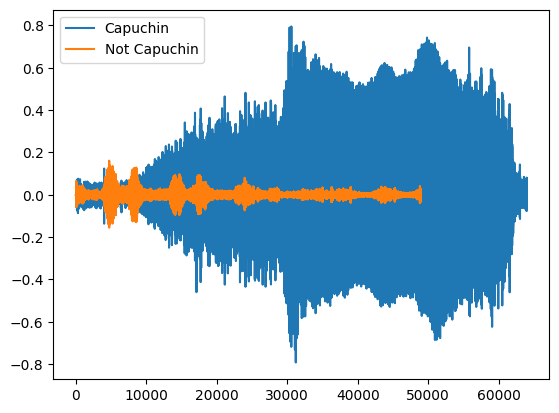

In [9]:
# Load and plot the first waveform
wav_capuchin = load_wav_16k_mono(CAPUCHIN_FILE)
plt.plot(wav_capuchin, label='Capuchin')

# Load and plot the second waveform
wav_not_capuchin = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
plt.plot(wav_not_capuchin, label='Not Capuchin')

# Add legend and show
plt.legend()
plt.show()

In [10]:
Audio(CAPUCHIN_FILE)

##Creating TF datasets and adding labels

In [11]:
pos = tf.data.Dataset.list_files(os.path.join('Parsed_Capuchinbird_Clips', '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join('Parsed_Not_Capuchinbird_Clips', '*.wav'))

In [12]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives).shuffle(1000)

In [13]:
time_duration = []
for file in os.listdir(os.path.join('Parsed_Capuchinbird_Clips')):
  tensor_wav = load_wav_16k_mono(os.path.join('Parsed_Capuchinbird_Clips', file))
  time_duration.append(round(len(tensor_wav)/16000,2))

In [14]:
print(f'Mean time duration of .wav file:',tf.math.reduce_mean(time_duration).numpy())
print(f'Min. time duration of .wav file:',tf.math.reduce_min(time_duration).numpy())
print(f'Max. time duration of .wav file:',tf.math.reduce_max(time_duration).numpy())

Mean time duration of .wav file: 3.3847926
Min. time duration of .wav file: 2.0
Max. time duration of .wav file: 5.0


Note: Looking at the time duration of .wav file we will consider 3 seconds time frame for training our CNN model. **3 secs X 16000 samples/second = 48000 samples**

##Preprocessing function to convert to spectogram

In [15]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [16]:
# Visualizing the spectogram for one positive sample.
filepath, label = positives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

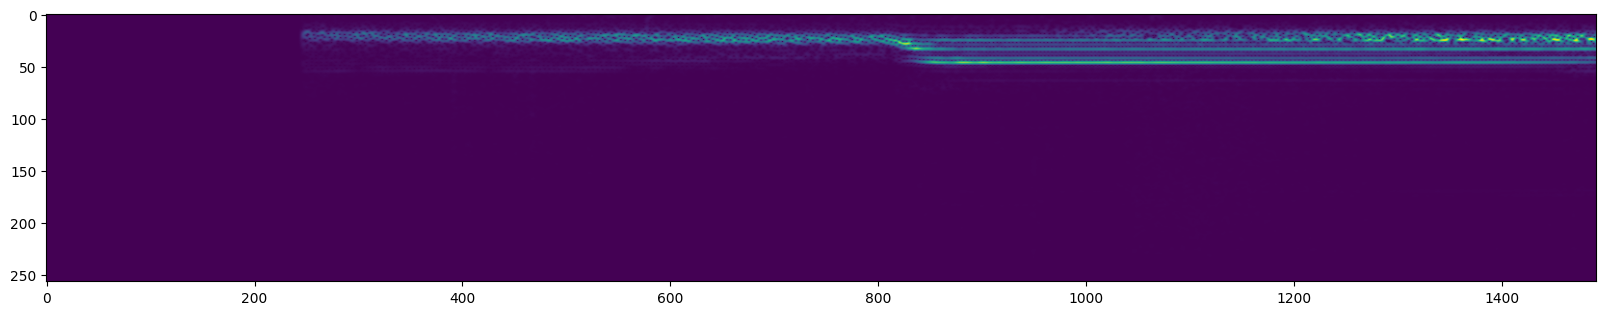

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(tf.transpose(spectrogram)[0])

In [18]:
# Visualizing the spectogram for one negative sample.
filepath, label = negatives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

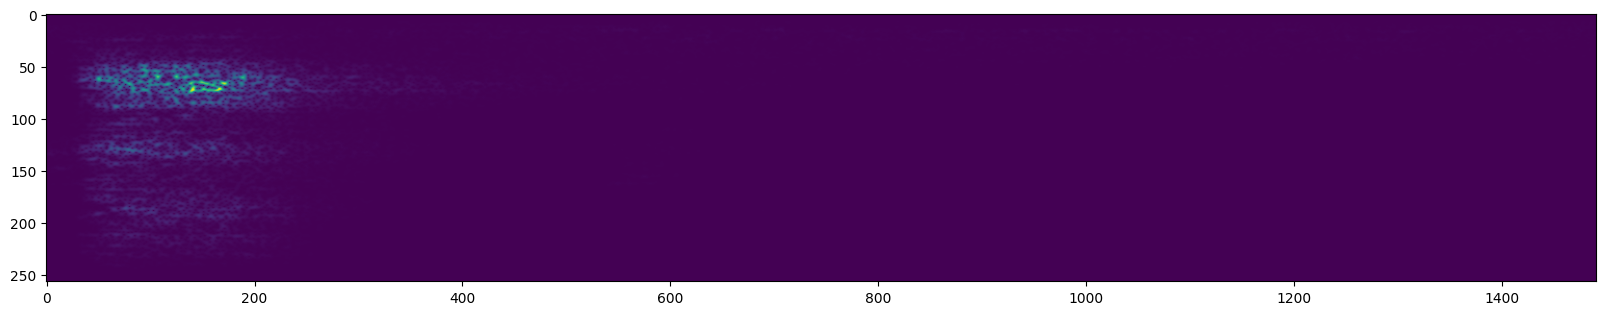

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(tf.transpose(spectrogram)[0])

## Creating a Tensorflow data pipeline

In [20]:
data = data.map(preprocess).cache().shuffle(buffer_size=1000).batch(8).prefetch(4)

In [21]:
samples, labels = data.as_numpy_iterator().next()
samples.shape

(8, 1491, 257, 1)

In [22]:
len(data)

102

Note: We will take 70% of data for training and 30% for testing.

## Splitting data into train and test

In [23]:
train = data.take(74)
test = data.skip(74).take(28)

##Building Deep learning model

In [24]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 128)               385240192 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 385,240,985
Trainable params: 385,240,985
Non-trainable params: 0
_________________________________________________________________


## Fit Model, View Loss and KPI Plots

In [27]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
74/74 [==============================] - 22s 129ms/step - loss: 11.8808 - recall: 0.8782 - precision: 0.7697 - val_loss: 0.1943 - val_recall: 1.0000 - val_precision: 0.9333
Epoch 2/4
74/74 [==============================] - 9s 126ms/step - loss: 0.0922 - recall: 0.9937 - precision: 0.9814 - val_loss: 0.0621 - val_recall: 0.9661 - val_precision: 0.9828
Epoch 3/4
74/74 [==============================] - 9s 124ms/step - loss: 0.0423 - recall: 0.9935 - precision: 0.9935 - val_loss: 0.0463 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
74/74 [==============================] - 10s 131ms/step - loss: 0.0336 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0362 - val_recall: 1.0000 - val_precision: 1.0000


In [34]:
hist.history

{'loss': [11.880846977233887,
  0.09222374856472015,
  0.042301028966903687,
  0.03356687352061272],
 'recall': [0.8782051205635071, 0.9937106966972351, 0.9934640526771545, 1.0],
 'precision': [0.7696629166603088,
  0.9813664555549622,
  0.9934640526771545,
  1.0],
 'val_loss': [0.1942625343799591,
  0.062079496681690216,
  0.04625288024544716,
  0.036156099289655685],
 'val_recall': [1.0, 0.9661017060279846, 1.0, 1.0],
 'val_precision': [0.9333333373069763, 0.982758641242981, 1.0, 1.0]}

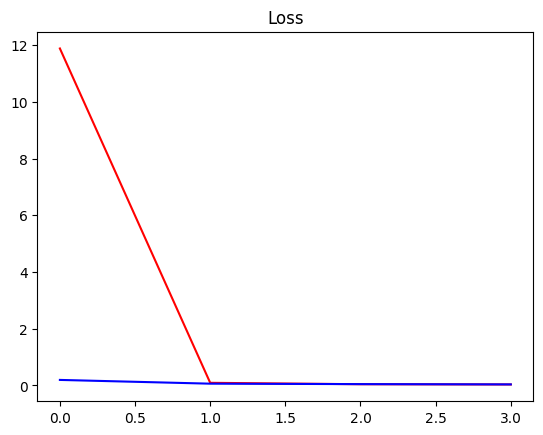

In [29]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

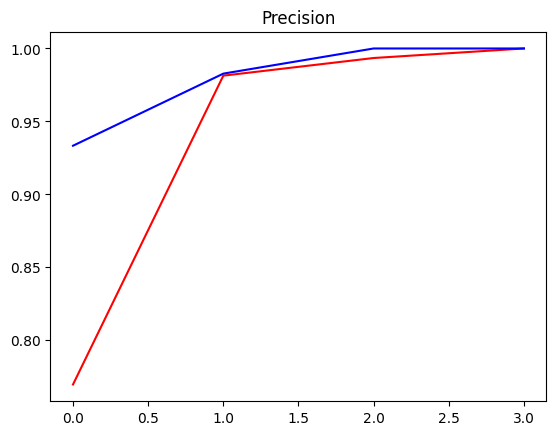

In [30]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

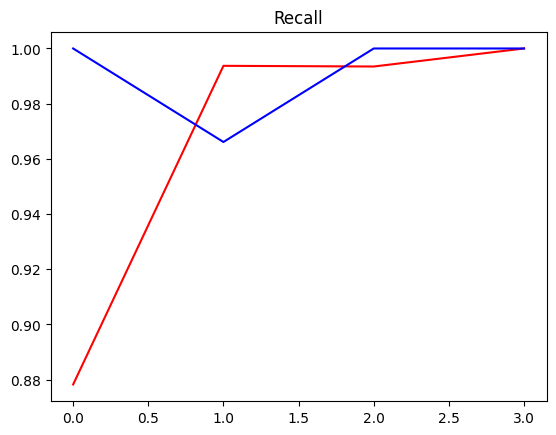

In [31]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [32]:
# Making prediction on a sample clip
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 0s 97ms/step


In [36]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat)

[1, 0, 0, 0, 1, 0, 1, 0]
